In [1]:
## 2012.1.1 - 2017.9.2 Baltimore Victim-Based Crime exploratory data analysis

# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
# read in kaggle 2012-2017 dataset
df = pd.read_csv("Resources/2012-2017_BPD_Victim_Based_Crime_Data.csv")
df.head()
## Data cleaning and preparation

#Post and CrimeCode dropped. Inside/Ouside cleaned. "Time of Day" and "Day of Week" series added. No null values have been dropped (for example, there are 10,000 nulls in "Inside/Outside", or 3% of the data). 

# data cleaning and organization

# remove series
df.drop(columns=["CrimeCode", "Post"], inplace=True)

# consolidate Inside/Outside values, merging "O" and "I" with "Outside" and "Inside"
df["Inside/Outside"] = df["Inside/Outside"].replace({"Outside": "O", "Inside": "I"})

# convert day to datetime data type
df.CrimeDate = pd.to_datetime(df.CrimeDate)

# change midnight for to_datetime
# create temp series CrimeTimeTemp for splitting data into Time of Day
df.loc[df.CrimeTime == "24:00:00", "CrimeTime"] = "00:00:00"
df["CrimeTimeTemp"] = pd.to_datetime(df.CrimeTime, format="%H:%M:%S")

# create bins and labels for morning, afternoon, evening, late night
# -1 because it kept populating "Time of Day" with NaN for any 0 hours (12am)
bins = [-1, 6, 12, 18, 24]
labels = ["Late Night", "Morning", "Afternoon", "Evening"]

# pd.cut likes ints, so dt.hour extracts the hour for comparison with bins
# remove CrimeTimeTemp from the df
df["Time of Day"] = pd.cut(
    df.CrimeTimeTemp.dt.hour, bins=bins, labels=labels
)
df.drop(columns=["CrimeTimeTemp"], inplace=True)

# add 'Day of Week' series
df["Day of Week"] = df["CrimeDate"].dt.day_name()

df


,CrimeDate,CrimeTime,Location,Description,Inside/Outside,Weapon,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,Time of Day,Day of Week
0,2017-09-02,23:30:00,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,Evening,Saturday
1,2017-09-02,23:00:00,800 NEWINGTON AVE,AUTO THEFT,O,NaN,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,Evening,Saturday
2,2017-09-02,22:53:00,600 RADNOR AV,SHOOTING,O,FIREARM,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1,Evening,Saturday
3,2017-09-02,22:50:00,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,Evening,Saturday
4,2017-09-02,22:31:00,100 LIGHT ST,COMMON ASSAULT,O,HANDS,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,Evening,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276524,2012-01-01,00:00:00,1400 JOH AVE,LARCENY,I,NaN,SOUTHWESTERN,Violetville,-76.67195,39.26132,"(39.2613200000, -76.6719500000)",OTHER - IN,1,Late Night,Sunday
276525,2012-01-01,00:00:00,5500 SINCLAIR LN,LARCENY,O,NaN,NORTHEASTERN,Frankford,-76.53829,39.32493,"(39.3249300000, -76.5382900000)",OTHER - OU,1,Late Night,Sunday
276526,2012-01-01,00:00:00,400 N PATTERSON PK AV,LARCENY,O,NaN,EASTERN,CARE,-76.58497,39.29573,"(39.2957300000, -76.5849700000)",STREET,1,Late Night,Sunday
276527,2012-01-01,00:00:00,5800 LILLYAN AV,BURGLARY,I,NaN,NORTHEASTERN,Glenham-Belhar,-76.54578,39.34701,"(39.3470100000, -76.5457800000)",APT. LOCKE,1,Late Night,Sunday


In [2]:
# find unique neighborhoods
list_neighborhoods = df["Neighborhood"].unique()
list_neighborhoods

array(['Brooklyn', 'Reservoir Hill', 'Winston-Govans', 'Carrollton Ridge',
       'Downtown West', 'Cherry Hill', 'Canton', 'Upton', 'Windsor Hills',
       'Berea', 'Edgewood', 'Central Park Heights', 'Frankford',
       'Holabird Industrial Park', 'Oliver', 'Madison Park',
       'Washington Hill', 'Waltherson', 'Better Waverly', 'Mondawmin',
       'Park Circle', 'Morgan State University', 'Downtown', 'Beechfield',
       'Inner Harbor', 'Coldstream Homestead Mont', 'Charles North',
       'Patterson Park Neighborho', 'Milton-Montford', 'Towanda-Grantley',
       'Hamilton Hills', 'Saint Josephs', 'Penn North', 'Ten Hills',
       'Harlem Park', 'CARE', 'Violetville', 'Parkside', 'Barclay',
       'Ashburton', 'Forest Park', 'Glen', 'Highlandtown',
       'Carroll - Camden Industri', 'Greenspring',
       'Canton Industrial Area', 'Boyd-Booth', 'Greektown',
       'Pleasant View Gardens', 'Fells Point',
       'Penrose/Fayette Street Ou', 'Upper Fells Point', 'Harwood',
       'Loch

In [3]:
# calculate crime by neighborhood
crime_per_neighborhood = df.groupby('Neighborhood').size().reset_index(name='Total_Crimes')

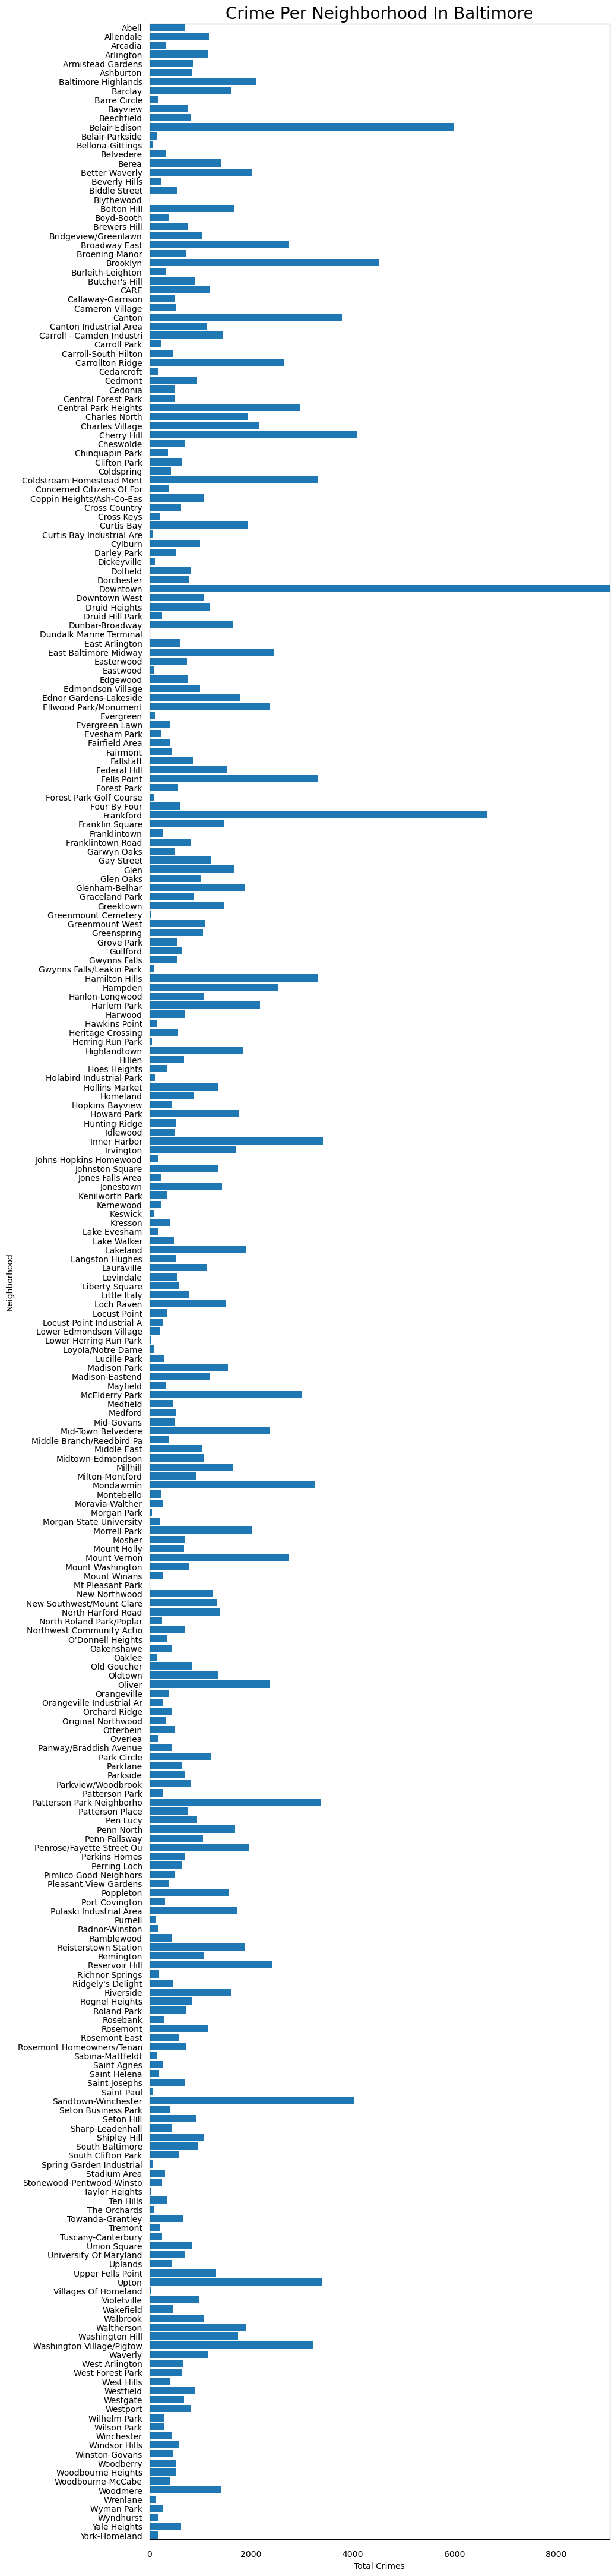

In [22]:
neighborhood = crime_per_neighborhood['Neighborhood']
crime = crime_per_neighborhood['Total_Crimes']

# create plot
fig, ax = plt.subplots(figsize =(10, 55))

# horizontal plot
ax.barh(neighborhood, crime)
 
# remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 5)

plt.margins(x=0, y=0)

# invert axis
ax.invert_yaxis()

# set labels
plt.ylabel('Neighborhood')
plt.xlabel('Total Crimes')
plt.title('Crime Per Neighborhood In Baltimore', fontsize = 20)

plt.show()

In [ ]:
# create data frame for crime type by hour of day 

In [8]:
crime_type = df['Description']
hour_of_day = df['Hour']

crime_type_by_hour_df = pd.DataFrame({"Type of Crime": crime_type,
                                      "Hour of Day": hour_of_day,
})

crime_type_by_hour_df

,Type of Crime,Hour of Day
0,ROBBERY - RESIDENCE,23
1,AUTO THEFT,23
2,SHOOTING,22
3,AGG. ASSAULT,22
4,COMMON ASSAULT,22
...,...,...
276524,LARCENY,0
276525,LARCENY,0
276526,LARCENY,0
276527,BURGLARY,0


In [9]:
# create 100% stacked chart to show proportions of different types of crime per hour of day

# cross tabulation proportions
cross_tab_prop = pd.crosstab(index=crime_type_by_hour_df['Hour of Day'],
                             columns=crime_type_by_hour_df['Type of Crime'],
                             normalize="index")
cross_tab_prop

Type of Crime,AGG. ASSAULT,ARSON,ASSAULT BY THREAT,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,ROBBERY - RESIDENCE,ROBBERY - STREET,SHOOTING
Hour of Day,,,,,,,,,,,,,,,
0,0.129042,0.008556,0.008634,0.115228,0.136499,0.190738,0.007221,0.165149,0.104553,0.004867,0.007849,0.011695,0.011931,0.081554,0.016484
1,0.141985,0.010445,0.008232,0.100823,0.120474,0.224661,0.008055,0.151014,0.086306,0.005400,0.008763,0.015137,0.013189,0.088342,0.017173
2,0.154758,0.012825,0.007329,0.089776,0.137902,0.248687,0.008428,0.090631,0.089410,0.007451,0.008794,0.015390,0.016490,0.095762,0.016367
3,0.142381,0.019463,0.008066,0.087498,0.156234,0.223742,0.007715,0.105734,0.081010,0.008943,0.012450,0.020866,0.018061,0.096440,0.011398
4,0.120368,0.016571,0.008055,0.085386,0.203913,0.199079,0.008285,0.104948,0.086306,0.011047,0.009436,0.022785,0.021404,0.091139,0.011277
5,0.088561,0.013969,0.008434,0.098840,0.249077,0.142594,0.005535,0.141539,0.099367,0.009752,0.010807,0.021613,0.013969,0.087243,0.008698
6,0.068293,0.006652,0.008204,0.114412,0.259424,0.120843,0.005765,0.175610,0.134812,0.006874,0.008647,0.012860,0.011308,0.062084,0.004213
7,0.058693,0.003338,0.010709,0.104312,0.313352,0.114882,0.002086,0.206815,0.129346,0.004312,0.002643,0.009597,0.007371,0.031015,0.001530
8,0.061260,0.003616,0.016632,0.088636,0.266736,0.129752,0.001446,0.235434,0.135124,0.004236,0.001343,0.009504,0.008574,0.035537,0.002169


In [10]:
# cross tabulation counts
cross_tab = pd.crosstab(index=crime_type_by_hour_df['Hour of Day'],
                        columns=crime_type_by_hour_df['Type of Crime'])
cross_tab

Type of Crime,AGG. ASSAULT,ARSON,ASSAULT BY THREAT,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,ROBBERY - RESIDENCE,ROBBERY - STREET,SHOOTING
Hour of Day,,,,,,,,,,,,,,,
0,1644,109,110,1468,1739,2430,92,2104,1332,62,100,149,152,1039,210
1,1604,118,93,1139,1361,2538,91,1706,975,61,99,171,149,998,194
2,1267,105,60,735,1129,2036,69,742,732,61,72,126,135,784,134
3,812,111,46,499,891,1276,44,603,462,51,71,119,103,550,65
4,523,72,35,371,886,865,36,456,375,48,41,99,93,396,49
5,336,53,32,375,945,541,21,537,377,37,41,82,53,331,33
6,308,30,37,516,1170,545,26,792,608,31,39,58,51,280,19
7,422,24,77,750,2253,826,15,1487,930,31,19,69,53,223,11
8,593,35,161,858,2582,1256,14,2279,1308,41,13,92,83,344,21


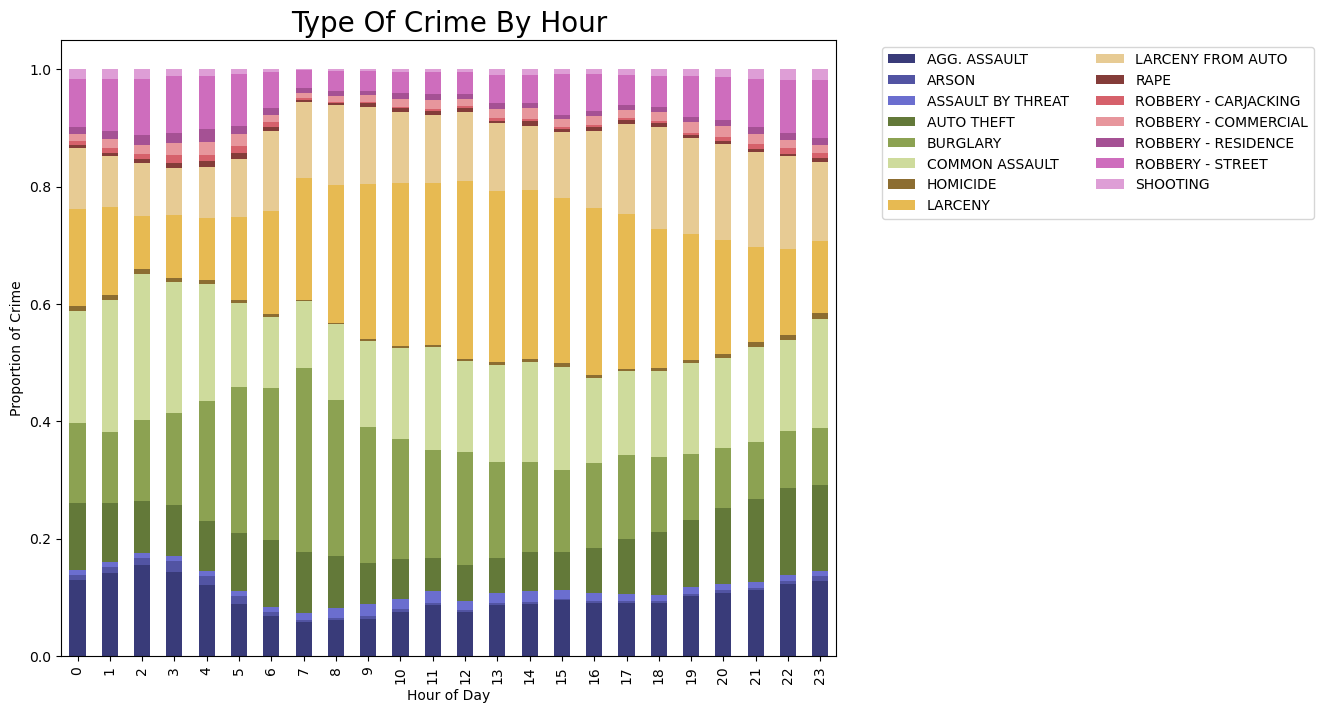

In [21]:
# create 100% stacked chart

cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(10, 8))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title("Type Of Crime By Hour", fontsize = 20)
plt.xlabel("Hour of Day")
plt.ylabel("Proportion of Crime")
plt.show()